In [236]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix

In [238]:
df=pd.read_csv(r'C:\Users\AARUSHI TANDON\Downloads\survey.csv')
# dropping irrelevant columns
df.drop([ 'state', 'comments'], axis=1, inplace=True)
#  Clean Age
df = df[(df['Age'] >= 15) & (df['Age'] <= 80)]

#Clean Gender
def clean_gender(g):
    g = g.lower()
    if 'male' in g: return 'Male'
    elif 'female' in g: return 'Female'
    elif 'f' in g: return 'Female'
    else: return 'Male'
df['Gender'] = df['Gender'].apply(clean_gender)
df=df.fillna("Unavailable Data")
df.head()

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Male,United States,Unavailable Data,No,Yes,Often,Jun-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,Male,United States,Unavailable Data,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,Unavailable Data,No,No,Rarely,Jun-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,Unavailable Data,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,Unavailable Data,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [239]:
#One-hot encode
X = df.drop('treatment', axis=1)
y = df['treatment'].map({'Yes': 1, 'No': 0})

X_encoded = pd.get_dummies(X)
joblib.dump(X_encoded.columns, 'model_columns.pkl')


['model_columns.pkl']

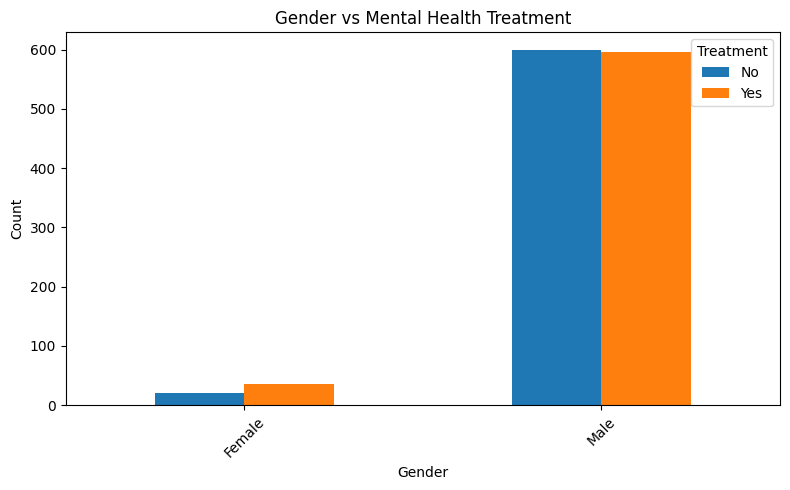

In [240]:

import matplotlib.pyplot as plt

gender_counts = df.groupby(['Gender', 'treatment']).size().unstack()

gender_counts.plot(kind='bar', stacked=False, figsize=(8,5))
plt.title("Gender vs Mental Health Treatment")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Treatment")
plt.tight_layout()
plt.show()


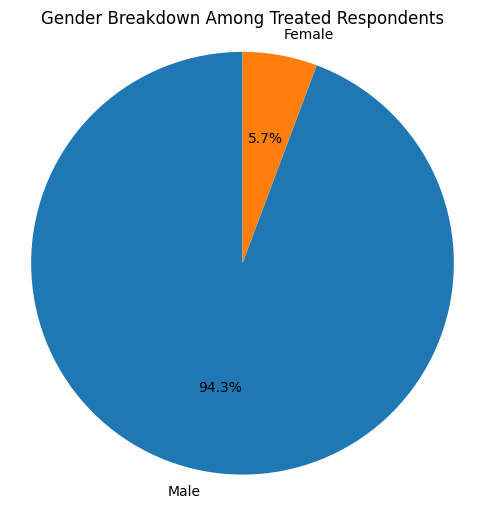

In [241]:



treated_gender = df[df['treatment'] == 'Yes']['Gender'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(treated_gender, labels=treated_gender.index, autopct='%1.1f%%', startangle=90)
plt.title("Gender Breakdown Among Treated Respondents")
plt.axis('equal')
plt.show()


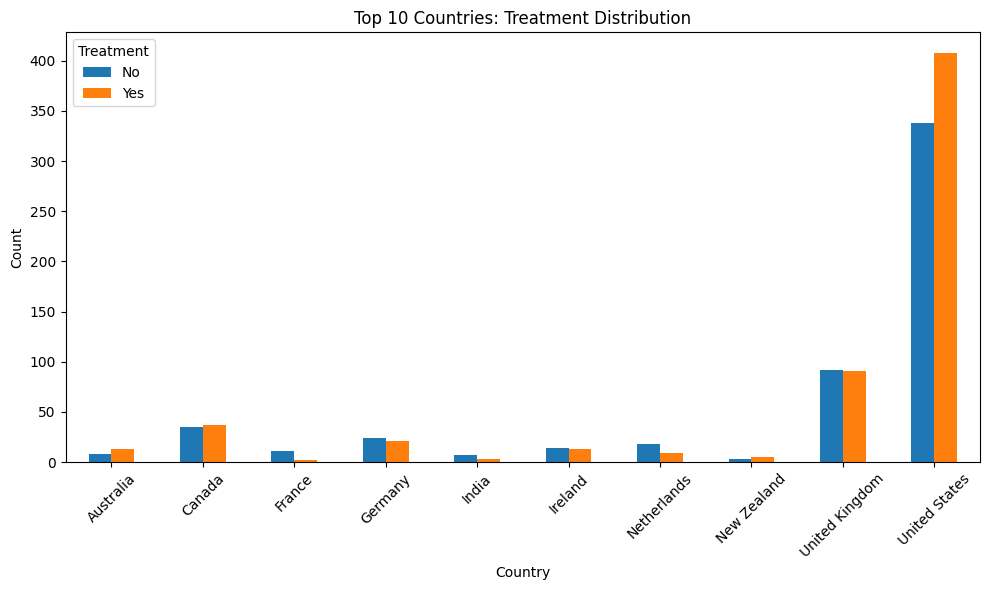

In [242]:
top_countries = df['Country'].value_counts().nlargest(10).index
subset = df[df['Country'].isin(top_countries)]
country_counts = subset.groupby(['Country', 'treatment']).size().unstack()

country_counts.plot(kind='bar', stacked=False, figsize=(10,6))
plt.title("Top 10 Countries: Treatment Distribution")
plt.xlabel("Country")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Treatment")
plt.tight_layout()
plt.show()


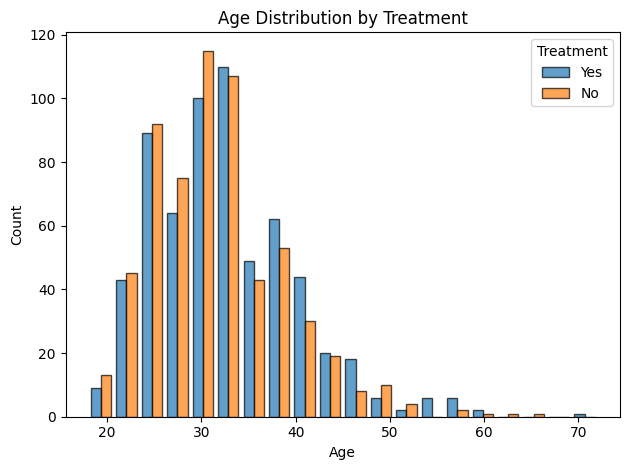

In [243]:
treated = df[df['treatment'] == 'Yes']['Age']
not_treated = df[df['treatment'] == 'No']['Age']

plt.hist([treated, not_treated], bins=20, label=['Yes', 'No'], alpha=0.7, edgecolor='black')
plt.title("Age Distribution by Treatment")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend(title="Treatment")
plt.tight_layout()
plt.show()


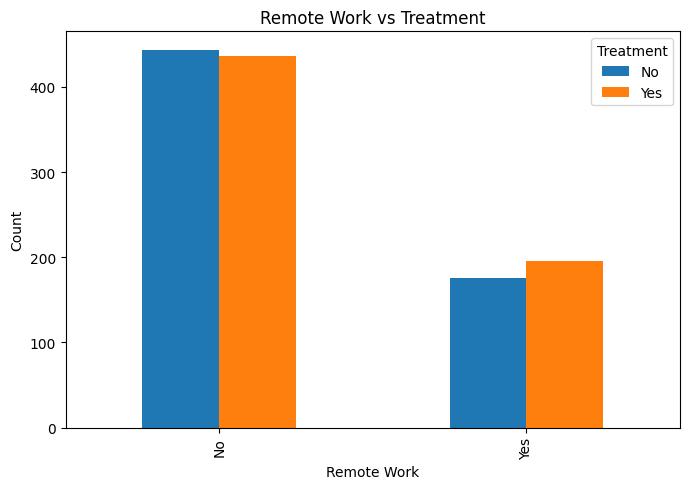

In [244]:
remote_counts = df.groupby(['remote_work', 'treatment']).size().unstack()

remote_counts.plot(kind='bar', figsize=(7,5))
plt.title("Remote Work vs Treatment")
plt.xlabel("Remote Work")
plt.ylabel("Count")
plt.legend(title="Treatment")
plt.tight_layout()
plt.show()


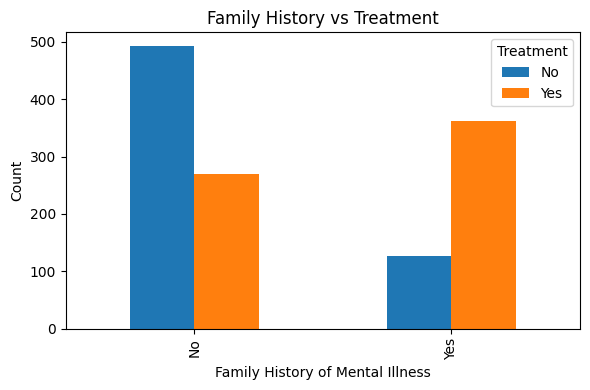

In [245]:
fam_counts = df.groupby(['family_history', 'treatment']).size().unstack()

fam_counts.plot(kind='bar', figsize=(6,4))
plt.title("Family History vs Treatment")
plt.xlabel("Family History of Mental Illness")
plt.ylabel("Count")
plt.legend(title="Treatment")
plt.tight_layout()
plt.show()


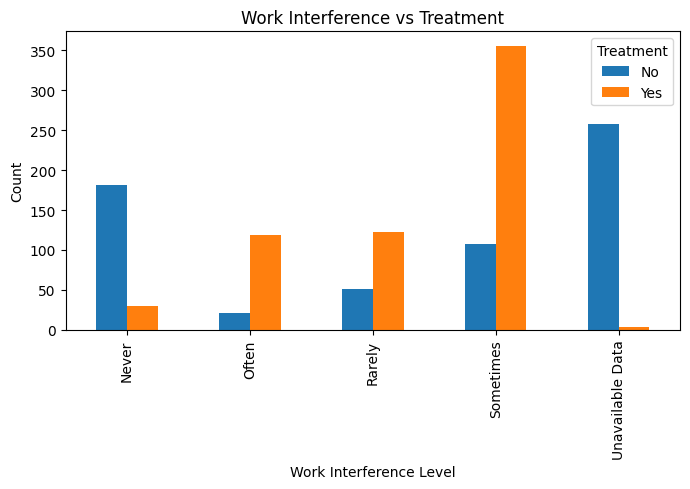

In [246]:
work_counts = df.groupby(['work_interfere', 'treatment']).size().unstack()

work_counts.plot(kind='bar', figsize=(7,5))
plt.title("Work Interference vs Treatment")
plt.xlabel("Work Interference Level")
plt.ylabel("Count")
plt.legend(title="Treatment")
plt.tight_layout()
plt.show()


In [247]:
#  Train-test split
X_train, X_test, y_train, y_test= train_test_split(X_encoded, y, test_size=0.2, random_state=42)
# Ensure all input features are float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Ensure target is also float32
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
    

In [248]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

# Add EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,            # Stop if val_loss doesn't improve for 5 epochs
    restore_best_weights=True,
    verbose=1
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',      # Watch this metric
    factor=0.5,              # Reduce LR by this factor
    patience=3,              # After 3 bad epochs
    min_lr=1e-5,             # Don't go below this
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    verbose=1,
    callbacks=[early_stop, lr_scheduler]
)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5105 - loss: 2.0404 - val_accuracy: 0.6300 - val_loss: 1.1517 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5273 - loss: 1.3256 - val_accuracy: 0.6850 - val_loss: 0.9761 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5660 - loss: 1.0445 - val_accuracy: 0.6200 - val_loss: 0.9035 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5797 - loss: 0.9429 - val_accuracy: 0.7500 - val_loss: 0.8446 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6366 - loss: 0.8342 - val_accuracy: 0.7700 - val_loss: 0.7924 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6300 - loss: 0.8209 - val_accuracy: 0.7800 - val_loss: 0.7680 - learning_rate: 0.0010
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6764 - loss: 0.7486 - 

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label=' Training accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation accuracy' , marker='o')
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
y_pred = model.predict(X_test).flatten()
y_pred_classes = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_classes))

In [ ]:

# Step 1: Predict
y_pred = model.predict(X_test).flatten()
y_pred_classes = (y_pred > 0.5).astype(int)

# Step 2: Classification report
print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_classes))

# Step 3: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Step 4: Plot it using ONLY Matplotlib
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add grid lines
plt.grid(False)

# Add text labels inside the boxes
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=14)

# Add tick labels
plt.xticks([0,1], ['No', 'Yes'])
plt.yticks([0,1], ['No', 'Yes'])

plt.colorbar()
plt.tight_layout()
plt.show()


In [ ]:
import joblib

# Save your model 
joblib.dump(model, 'mental_health_nn_model.pkl')

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
joblib.dump(scaler, 'mental_health_scaler.pkl')  # ✅ this is what you need
model.save("mental_health_nn_model.keras")  # Save in the new format



In [ ]:
#Logistic Regression model as a comparison.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

print(classification_report(y_test, y_pred_lr))
# confusion matrix plot


In [ ]:
import os
os.getcwd()
